In [1]:
from __future__ import division, print_function
import sympy as sm
import sympy.physics.mechanics as me
me.init_vprinting()

Now specify the number of links, $n$. I'll start with 5 since the Wolfram folks only showed four.

In [2]:
n = 9
do_sim = True

**mechanics** will need the generalized coordinates, generalized speeds, and the input force which are all time dependent variables and the bob masses, link lengths, and acceleration due to gravity which are all constants. Time, $t$, is also made available because we will need to differentiate with respect to time.

In [3]:
import numpy as np
q = me.dynamicsymbols('q:{}'.format(n + 1))  # Generalized coordinates
u = me.dynamicsymbols('dq:{}'.format(n + 1))  # Generalized speeds
f = me.dynamicsymbols('f:{}'.format(n))      # Force applied to the cart
    
# m = sm.symbols('m:{}'.format(n + 1))         # Mass of each bob
# l = sm.symbols('l:{}'.format(n))             # Length of each link

m = (0.01 / n)*np.ones(n+1,)
l = (1. / n)*np.ones(n+1,)
g = 9.81
t = sm.symbols('t')                     # Gravity and time

Now we can create and inertial reference frame $I$ and define the point, $O$, as the origin.

In [4]:
I = me.ReferenceFrame('I')  # Inertial reference frame
O = me.Point('O')           # Origin point
O.set_vel(I, 0)             # Origin's velocity is zero

Secondly, we define the define the first point of the pendulum as a particle which has mass. This point can only move laterally and represents the motion of the "cart".

In [5]:
P0 = me.Point('P0')                 # Hinge point of top link
P0.set_pos(O, q[0] * I.x)           # Set the position of P0    
P0.set_vel(I, u[0] * I.x)           # Set the velocity of P0
Pa0 = me.Particle('Pa0', P0, m[0])  # Define a particle at P0

Now we can define the $n$ reference frames, particles, gravitational forces, and kinematical differential equations for each of the pendulum links. This is easily done with a loop.

In [6]:
frames = [I]                              # List to hold the n + 1 frames
points = [P0]                             # List to hold the n + 1 points
particles = [Pa0]                         # List to hold the n + 1 particles
forces = [(P0, f[0] * I.x - m[0] * g * I.y)] # List to hold the n + 1 applied forces, including the input force, f
kindiffs = [q[0].diff(t) - u[0]]          # List to hold kinematic ODE's

for i in range(n):
    Bi = I.orientnew('B' + str(i), 'Axis', [q[i + 1], I.z])   # Create a new frame
    Bi.set_ang_vel(I, u[i + 1] * I.z)                         # Set angular velocity
    frames.append(Bi)                                         # Add it to the frames list

    Pi = points[-1].locatenew('P' + str(i + 1), l[i] * Bi.x)  # Create a new point
    Pi.v2pt_theory(points[-1], I, Bi)                         # Set the velocity
    points.append(Pi)                                         # Add it to the points list
    
    Pai = me.Particle('Pa' + str(i + 1), Pi, m[i + 1])        # Create a new particle
    particles.append(Pai)                                     # Add it to the particles list

    forces.append((Pi, -m[i + 1] * g * I.y))                  # Set the force applied at the point
    kindiffs.append(q[i + 1].diff(t) - u[i + 1])              # Define the kinematic ODE:  dq_i / dt - u_i = 0
for i in range(n-1):
    forces.append((frames[i+1], f[i+1]*frames[i].z))

With all of the necessary point velocities and particle masses defined, the `KanesMethod` class can be used to derive the equations of motion of the system automatically.

In [7]:
# forces

In [8]:
kane = me.KanesMethod(I, q_ind=q, u_ind=u, kd_eqs=kindiffs)  # Initialize the object
fr, frstar = kane.kanes_equations(forces, particles)         # Generate EoM's fr + frstar = 0

/Users/shenshen/veril/ENV/lib/python3.7/site-packages/sympy/physics/mechanics/kane.py:536: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


The equations of motion are quite long as can been seen below. This is the general nature of most non-simple mutlibody problems. That is why a SymPy is so useful; no more mistakes in algebra, differentiation, or copying hand written equations. Note that `trigsimp` can take quite a while to complete for extremely large expressions. Below we print $\tilde{M}$ and $\tilde{f}$ from $\tilde{M}\dot{u}=\tilde{f}$ to show the size of the expressions.

In [9]:
# sm.trigsimp(kane.mass_matrix)

$\tilde{M}$ is a function of the constant parameters and the configuration.

In [10]:
# me.find_dynamicsymbols(kane.mass_matrix)

In [11]:
# sm.trigsimp(kane.forcing)

$\tilde{f}$ is a function of the constant parameters, configuration, speeds, and the applied force.

In [12]:
# me.find_dynamicsymbols(kane.forcing)

Controller Design
=================

The n-link pendulum can be balanced such that all of the links are inverted above the cart by applying the correct lateral force to the cart. We can design a full state feedback controller based from a linear model of the pendulum about its upright equilibrium point. We'll start by specifying the equilibrium point and parameters in dictionaries. We make sure to use SymPy types in the equilibrium point to ensure proper cancelations in the linearization.

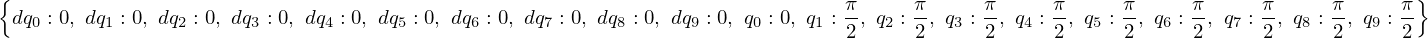

In [13]:
equilibrium_point = [sm.S(0)] + [sm.pi / 2] * (len(q) - 1) + [sm.S(0)] * len(u)                           
equilibrium_dict = dict(zip(q + u, equilibrium_point))
equilibrium_dict

The `KanesMethod` class has method that linearizes the forcing vector about generic state and input perturbation vectors. The equilibrium point and numerical constants can then be substituted in to give the linear system in this form: $M\dot{x}=F_Ax+F_Br$. The state and input matrices, $A$ and $B$, can then be computed by left side multiplication by the inverse of the mass matrix: $A=M^{-1}F_A$ and $B=M^{-1}F_B$.

In [14]:
M, F_A, F_B, r = kane.linearize(new_method=True, op_point=equilibrium_dict)

In [15]:
# sm.simplify(M)

In [16]:
# sm.simplify(F_A)

In [17]:
# sm.simplify(F_B)

Now the numerical $A$ and $B$ matrices can be formed. First substitute numerical parameter values into $M$, $F_A$, and $F_B$.

In [18]:
# parameter_dict = dict(zip(parameters, parameter_vals))
# parameter_dict

In [19]:
M_num = sm.matrix2numpy(M, dtype=float)
F_A_num = sm.matrix2numpy(F_A, dtype=float)
F_B_num = sm.matrix2numpy(F_B, dtype=float)
A = np.linalg.solve(M_num, F_A_num)
B = np.linalg.solve(M_num ,F_B_num)

In [20]:
# print(A)

In [21]:
# print(B)

Also convert `equilibrium_point` to a numeric array:

In [22]:
equilibrium_point = np.asarray([x.evalf() for x in equilibrium_point], dtype=float)

Now that we have a linear system, the SciPy package can be used to design an optimal controller for the system.

So now we can compute the optimal gains with a linear quadratic regulator. I chose identity matrices for the weightings for simplicity.

In [23]:
from scipy.linalg import solve_continuous_are
Q = np.eye(A.shape[0])
R = np.eye(B.shape[1])
S = solve_continuous_are(A, B, Q, R);
K = np.dot(np.dot(np.linalg.inv(R), B.T),  S)

The gains can now be used to define the required input during simulation to stabilize the system. The input $r$ is simply the gain vector multiplied by the error in the state vector from the equilibrium point, $r(t)=K(x_{eq} - x(t))$.

In [24]:
dynamic = q + u +f   # Make a list of the states
# dynamic.append(f)  # Add the input force
print(len(dynamic))
M_func = sm.lambdify(dynamic, kane.mass_matrix_full) # Create a callable function to evaluate the mass matrix 
f_func = sm.lambdify(dynamic, kane.forcing_full)     # Create a callable function to evaluate the forcing vector 

29


In [25]:
arm_length = 1. / n                          # The maximum length of the pendulum is 1 meter
bob_mass = 0.01 / n                          # The maximum mass of the bobs is 10 grams
parameters = [g, m[0]]                       # Parameter definitions starting with gravity and the first bob
parameter_vals = [9.81, 0.01 / n]            # Numerical values for the first two
for i in range(n):                           # Then each mass and length
    parameters += [l[i], m[i + 1]]            
    parameter_vals += [arm_length, bob_mass]

Animation
=========

matplotlib now includes very nice animation functions for animating matplotlib plots. First we import the necessary functions for creating the animation.

In [26]:
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(8.0, 6.0)
import numpy as np
from numpy.linalg import solve
from scipy.integrate import odeint

from matplotlib import animation
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt

In [27]:
def right_hand_side(x, t, args):
    """Returns the derivatives of the states.

    Parameters
    ----------
    x : ndarray, shape(2 * (n + 1))
        The current state vector.
    t : float
        The current time.
    args : ndarray
        The constants.

    Returns
    -------
    dx : ndarray, shape(2 * (n + 1))
        The derivative of the state.
    
    """
    div = equilibrium_point - x
    div[:n+1] = np.sin(div[:n+1])
    r = np.dot(K, div)    # The controller   
    arguments = np.hstack((x, r))     # States, input, and parameters
    dx = np.array(solve(M_func(*arguments), # Solving for the derivatives
                        f_func(*arguments))).T[0]
    
    return dx

Now we can simulate and animate the system to see if the controller works.

In [28]:
t = np.linspace(0.0, 10.0, num=500)
def sim_once(x0):
#     x0 = np.hstack((0,
#                 (np.pi/ 2) * np.ones(len(q) - 1) - np.random.uniform(-np.pi,np.pi,(len(q) - 1)),
#                 2* np.ones(len(u))))
    t = np.linspace(0.0, 10.0, num=500)
    x = odeint(right_hand_side, x0, t, args=(parameter_vals,))

    
#     lines = plt.plot(t, x[:, x.shape[1] // 2:])
#     lab = plt.xlabel('Time [sec]')
#     leg = plt.legend(dynamic[x.shape[1] // 2:])
    
#     lines = plt.plot(t, x[:, x.shape[1] // 2:])
#     lab = plt.xlabel('Time [sec]')
#     leg = plt.legend(dynamic[x.shape[1] // 2:])
    lines = plt.plot(t, x)
    lab = plt.xlabel('Time [sec]')
    leg = plt.legend(dynamic)
    return x

The plots show that we seem to have a stable system.

In [29]:
if do_sim: 
    lines = plt.plot(t, x[:, :x.shape[1] // 2])
    lab = plt.xlabel('Time [sec]')
    leg = plt.legend(dynamic[:x.shape[1] // 2])

NameError: name 'x' is not defined

In [ ]:
if do_sim:
    lines = plt.plot(t, x[:, x.shape[1] // 2:])
    lab = plt.xlabel('Time [sec]')
    leg = plt.legend(dynamic[x.shape[1] // 2:])

In [ ]:
def animate_pendulum(t, states, length, filename=None):
    """Animates the n-pendulum and optionally saves it to file.

    Parameters
    ----------
    t : ndarray, shape(m)
        Time array.
    states: ndarray, shape(m,p)
        State time history.
    length: float
        The length of the pendulum links.
    filename: string or None, optional
        If true a movie file will be saved of the animation. This may take some time.

    Returns
    -------
    fig : matplotlib.Figure
        The figure.
    anim : matplotlib.FuncAnimation
        The animation.

    """
    # the number of pendulum bobs
    numpoints = states.shape[1] // 2

    # first set up the figure, the axis, and the plot elements we want to animate
    fig = plt.figure()
    
    # some dimesions
    cart_width = 0.4
    cart_height = 0.2
    
    # set the limits based on the motion
    xmin = np.around(states[:, 0].min() - cart_width / 2.0, 1)
    xmax = np.around(states[:, 0].max() + cart_width / 2.0, 1)
    
    # create the axes
    ax = plt.axes(xlim=(xmin, xmax), ylim=(-1.1, 1.1), aspect='equal')
    
    # display the current time
    time_text = ax.text(0.04, 0.9, '', transform=ax.transAxes)
    
    # create a rectangular cart
    rect = Rectangle([states[0, 0] - cart_width / 2.0, -cart_height / 2],
                     cart_width, cart_height, fill=True, color='red',
                     ec='black')
    ax.add_patch(rect)
    
    # blank line for the pendulum
    line, = ax.plot([], [], lw=2, marker='o', markersize=6)

    # initialization function: plot the background of each frame
    def init():
        time_text.set_text('')
        rect.set_xy((0.0, 0.0))
        line.set_data([], [])
        return time_text, rect, line,

    # animation function: update the objects
    def animate(i):
        time_text.set_text('time = {:2.2f}'.format(t[i]))
        rect.set_xy((states[i, 0] - cart_width / 2.0, -cart_height / 2))
        x = np.hstack((states[i, 0], np.zeros((numpoints - 1))))
        y = np.zeros((numpoints))
        for j in np.arange(1, numpoints):
            x[j] = x[j - 1] + length * np.cos(states[i, j])
            y[j] = y[j - 1] + length * np.sin(states[i, j])
        line.set_data(x, y)
        return time_text, rect, line,

    # call the animator function
    anim = animation.FuncAnimation(fig, animate, frames=len(t), init_func=init,
            interval=t[-1] / len(t) * 1000, blit=True, repeat=False)
    
    # save the animation if a filename is given
    if filename is not None:
        anim.save(filename, fps=30, codec='libx264')
    return anim

In [ ]:
if do_sim:
    anim = animate_pendulum(t, x, arm_length)

    # Set up formatting for the movie files
    Writer = animation.writers['ffmpeg']
    writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
    f_name = './link' + str(n)+ '/closed-loop.mp4'

    anim.save(f_name,writer = 'ffmpeg')
    anim.save('closed-loop.mp4',writer = 'ffmpeg')

In [ ]:
from IPython.display import HTML
html = \
"""
<video width="640" height="480" controls>
  <source src='closed-loop.mp4' type="video/mp4">
Your browser does not support the video tag, check out the YouTube version instead: http://youtu.be/SpgBHqW9om0
</video>
"""
HTML(html)

### Feedback the LQR controller for the closed-loop EOM:

In [30]:
states = np.array(q + u)
div = equilibrium_point - states
div

array([-q0(t), 1.5707963267949 - q1(t), 1.5707963267949 - q2(t),
       1.5707963267949 - q3(t), 1.5707963267949 - q4(t),
       1.5707963267949 - q5(t), 1.5707963267949 - q6(t),
       1.5707963267949 - q7(t), 1.5707963267949 - q8(t),
       1.5707963267949 - q9(t), -dq0(t), -dq1(t), -dq2(t), -dq3(t),
       -dq4(t), -dq5(t), -dq6(t), -dq7(t), -dq8(t), -dq9(t)], dtype=object)

### Turn the feedback on the small angle $\theta$ to feedback on the $\sin(\theta)$

In [31]:
from sympy import sin, cos
div_in_trig = div
for i in range(n):
    div_in_trig[i+1] = sin(div[i+1])
div_in_trig

array([-q0(t), -sin(q1(t) - 1.5707963267949),
       -sin(q2(t) - 1.5707963267949), -sin(q3(t) - 1.5707963267949),
       -sin(q4(t) - 1.5707963267949), -sin(q5(t) - 1.5707963267949),
       -sin(q6(t) - 1.5707963267949), -sin(q7(t) - 1.5707963267949),
       -sin(q8(t) - 1.5707963267949), -sin(q9(t) - 1.5707963267949),
       -dq0(t), -dq1(t), -dq2(t), -dq3(t), -dq4(t), -dq5(t), -dq6(t),
       -dq7(t), -dq8(t), -dq9(t)], dtype=object)

In [32]:
feedback = np.dot(K, div_in_trig)

forces = [(P0, feedback[0] * I.x - m[0] * g * I.y)] # List to hold the n + 1 applied forces, including the input force, f

for i in range(n):
    forces.append((Pi, -m[i + 1] * g * I.y))                  # Set the force applied at the point
for i in range(n-1):
    forces.append((frames[i+1], feedback[i+1]*frames[i].z))

kane_cl = me.KanesMethod(I, q_ind=q, u_ind=u, kd_eqs=kindiffs)
fr_cl, frstar_cl = kane_cl.kanes_equations(forces, particles)

/Users/shenshen/veril/ENV/lib/python3.7/site-packages/sympy/physics/mechanics/kane.py:536: SymPyDeprecationWarning: 

The kanes_equation() argument order has been deprecated since SymPy
1.1. Use switched argument order to update your code, For example:
kanes_equations(loads, bodies) > kanes_equations(bodies, loads).
instead. See https://github.com/sympy/sympy/issues/10945 for more
info.  The API for kanes_equations() has changed such that the loads
(forces and torques) are now the second argument and is optional with
None being the default.

  issue=10945, deprecated_since_version="1.1").warn()


In [33]:
full_mass = (kane_cl.mass_matrix_full)
full_force = (kane_cl.forcing_full)

### Double check the EOM is in terms of the trigs and velocities only

In [34]:
full_mass_num = full_mass.subs(equilibrium_dict)
full_force_num = full_force.subs(equilibrium_dict)

Expand trig of angle differnce into absolute angle trigs

In [35]:
# sm.expand_trig(forcesmatrix)

### Double check the CL dynamics in terms of $q$ $\dot q$ are stable

In [36]:
M_cl, F_A_cl, F_B_cl, r_cl = kane_cl.linearize(new_method=True, op_point=equilibrium_dict)
M_num_cl = sm.matrix2numpy(M_cl, dtype=float)
F_A_num_cl = sm.matrix2numpy(F_A_cl, dtype=float)
A_cl = np.linalg.solve(M_num_cl, F_A_num_cl)
# A_cl

In [37]:
# full_force

In [38]:
np.linalg.eig(A_cl)[0]
from scipy.linalg import solve_lyapunov
P = solve_lyapunov(A_cl.T, -np.eye(A_cl.shape[0]))

In [39]:
# orig_basis = states - equilibrium_point
# orig_basis
V = sm.expand_trig((div_in_trig).T@P@(div_in_trig))
# V
sm.N(V.subs(equilibrium_dict))

# Do recasting!

## Recast States

In [40]:
sinstates = me.dynamicsymbols('s:{}'.format(n+1))
cosstates = me.dynamicsymbols('c:{}'.format(n+1))
sinstates = sinstates[1:]
cosstates = cosstates[1:]
velocities = u

In [41]:
recast_states = [q[0]]
for i in range(n):
    recast_states = recast_states + [sinstates[i]] + [cosstates[i]]
recast_states +=  u

recast_states

### recasted fixed point

In [42]:
recast_fix_point = [sm.S(0)] + [sm.S(1), sm.S(0)] * (n) +  [sm.S(0)] * (n+1)
print(recast_fix_point)
recast_fix_point_dict = dict(zip(recast_states, recast_fix_point))

[0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


#### Recasting the Lyapunov Method 1 (angle replacement)

In [43]:
# first recast small angle squared

# small_squared = [i**2 for i in q[1:]]
# small_squared_cos = [2-2*i for i in cosstates]
# recat_lyap_dict = dict(zip(small_squared,small_squared_cos))
# V_recast = V.subs(recat_lyap_dict)
# V_recast

In [44]:
# next recast the small angle themselves

# V_recast = V_recast.subs(dict(zip(q[1:],sinstates)))
# V_recast

#### Recasting the Lyapunov Method 2 (direct replacement)

In [45]:
# recast_basis = [q[0]] + sinstates + u
# V_recast = sm.expand(recast_basis@P@recast_basis)

In [46]:
# small_squared_cos = [2-2*i for i in cosstates]
# # recast_basis_one = [q[0]] + sinstates + u
# # V1 = sm.expand(recast_basis@P@recast_basis)
# # me.find_dynamicsymbols(V_recast)
# small_squared_cos
# V_recast.subs(recast_fix_point_dict)

## Recasting the dynamics

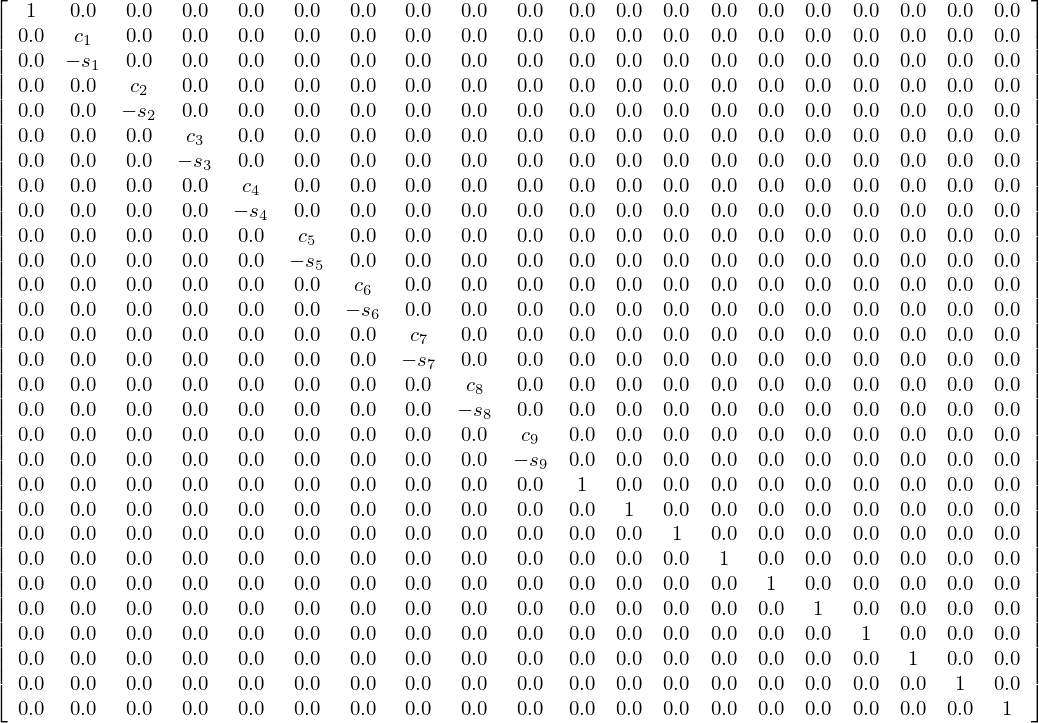

In [47]:
recast_transformation=sm.Matrix(np.zeros((3*n+2, 2*n+2)))
recast_transformation[0,0]=sm.S(1)
for i in range(n):
    recast_transformation[2*i+1,i+1] = cosstates[i]
    recast_transformation[2*i+2,i+1] = - sinstates[i]
for i in range(n+1):
    recast_transformation[-i-1,-i-1] = sm.S(1)
recast_transformation

In [48]:
sins=[sin(i) for i in q[1:]]
coss=[cos(i) for i in q[1:]]
key = sins+coss
values = sinstates + cosstates
recast_sim_dict = dict(zip(key,values))
recast_sim_dict

In [49]:
V_recast = V.subs(recast_sim_dict)
V_recast.subs(recast_fix_point_dict)

### recast the mass and force matrices

In [50]:
full_mass_recast = full_mass.subs(recast_sim_dict)
full_force_recast = sm.expand_trig(full_force).subs(dict(zip(key,values)))

full_mass_recast_num = full_mass_recast.subs(recast_fix_point_dict)
full_force_recast_num = full_force_recast.subs(recast_fix_point_dict)

In [51]:
# debug: should match the original form
assert(full_mass_num == full_mass_recast_num)
assert(full_force_num == full_force_recast_num)

### symbolic transformation of the dyanmics, involing mass inversion, bad

### do linearization in the [s,c,t] coordinate, getting non-Hurwitz A, so go back to small-angle approx. of V

In [52]:
# ddq = recast_mass.inv()@recast_force  ## doubledots(q) expressed in q, dq
# dsdc = recast_transformation@ddq 

# # dynamics_recast = sm.Matrix([dq0, dsdc, ddq])
# # dynamics_recast.shape

# dynamics_recast = recast_transformation@full_mass_recast.inv()@full_force_recast
# dynamics_recast.shape

In [53]:
# A_recast = sm.matrix2numpy(dynamics_recast.jacobian(recast_states).subs(recast_fix_point_dict), dtype=float)
# ddq_A = sm.matrix2numpy(ddq.jacobian(recast_states).subs(recast_fix_point_dict), dtype=float)

In [54]:
# dq0_A = np.zeros(2*n+2+n)
# dq0_A[-n-1]=1
# A_recast = np.vstack((dq0_A, dsdc_A,ddq_A))
# A_recast

In [55]:
# np.linalg.eig(A_recast)[0]
# P_recast = solve_lyapunov(A_recast.T, -np.eye(A_recast.shape[0]))
# np.linalg.eig(P_recast)[0]

In [56]:
# direc_v_recast = sm.simplify((recast_states - recast_fix_point).T@P@(recast_states - recast_fix_point))
# direc_v_recast

In [57]:
import itertools
def get_monomials(x, deg, rm_one):
#     c = 1 if isinstance(x[0], float) else Expression(1)
    c =1
    _ = itertools.combinations_with_replacement(np.append(c, x), deg)
    basis = [np.prod(j) for j in _]
    if rm_one:
        basis = basis[1:]
    return (basis[:: -1])

In [58]:
xxd = (np.array(recast_states)@np.array(recast_states))
psi = sm.Matrix(get_monomials(recast_states, 2, False))

In [59]:
def sample():
    V_num =[]
    xxd_num = []
    psi_num = []
    alpha= np.random.randn(2*n+2)
    beta = np.random.randn(2*n+2)
    t = sm.Symbol('t',real=True)
    old_states_dict = dict(zip(states, alpha*t+beta))
#     old_states_dict
    
    angle = np.random.uniform(-np.pi,np.pi,n)
    sin_samples, cos_samples = np.sin(angle), np.cos(angle)
    trig_sample_dict = dict(zip(sinstates + cosstates, np.concatenate([sin_samples, cos_samples])))
#     trig_sample_dict
    old_states_dict.update(trig_sample_dict)
#     print(old_states_dict)

    phi = V_recast.diff((recast_states,1))
    this_phi = sm.simplify(phi.subs(old_states_dict))
#     print(this_phi)
#     this_phi.shape

    this_mass = sm.matrix2numpy(sm.simplify(full_mass_recast.subs(old_states_dict)),dtype=float)
    this_mass_inv = np.linalg.inv(this_mass)
#     print(this_mass_inv)
#     this_mass_inv

    this_force = sm.matrix2numpy(sm.simplify(full_force_recast.subs(old_states_dict)))
#     this_force

#     this_ddq = this_mass_inv@this_force
# #     this_ddq.shape

    this_recast_transform = sm.matrix2numpy(recast_transformation.subs(trig_sample_dict),dtype=float)
#     this_dsdc = this_recast_transform@this_ddq
# #     this_dsdc

#     this_dq0=old_states_dict[u[0]]
#     this_f = np.vstack((this_dq0, this_dsdc, this_ddq))
    this_f = this_recast_transform@this_mass_inv@this_force
#     print(this_f)
    this_Vdot = this_phi@this_f

    t_num=sm.solve(this_Vdot,t)
    
    
    if len(t_num)>0:
        
        for i in t_num:
            sol_dict = dict(zip(states, alpha*i+beta))
            sol_dict.update(trig_sample_dict)
            print(sol_dict)
            
            V_eval = V_recast.subs(sol_dict)
            print(V_eval)
            if V_eval <=1e4:
                print('found root')
                V_num.append(V_eval)
                xxd_num.append((xxd.subs(sol_dict)))
                psi_num.append(sm.matrix2numpy(psi.subs(sol_dict), dtype=float))
    else:
        print('no root')
        sol_dict = []
    return V_num, xxd_num, psi_num, sol_dict

In [60]:
allV=[]
allxxd = []
allpsi = []
all_sol_dicts=[]

In [ ]:
while len(allV)<=300:
    V_num, xxd_num, psi_num, sol_dict = sample()
    allV += V_num
    allxxd += xxd_num
    allpsi += psi_num
    all_sol_dicts += sol_dict

no root
{q0(t): 326441.270618602, q1(t): 7464.88835046916, q2(t): 56986.0601260858, q3(t): -462703.115987852, q4(t): -22064.2716982543, q5(t): 215395.597894304, q6(t): -364506.727571869, q7(t): -801616.744108751, q8(t): -139517.969935016, q9(t): 389613.845572494, dq0(t): -1696718.96355943, dq1(t): -170220.481897134, dq2(t): 348609.779955798, dq3(t): 444874.470772787, dq4(t): -151202.804811365, dq5(t): 967322.043562655, dq6(t): 721077.807060606, dq7(t): 761826.336124920, dq8(t): 734698.900625776, dq9(t): -79677.6790446121, s1(t): -0.8005355548641087, s2(t): 0.9644105908272069, s3(t): 0.48427849177213195, s4(t): -0.7570463532869178, s5(t): 0.030427481076450078, s6(t): -0.23758763357725265, s7(t): 0.9425926650880782, s8(t): -0.03182692086680472, s9(t): 0.7795109097917069, c1(t): -0.5992852621234848, c2(t): 0.2644091759003793, c3(t): 0.8749139057112472, c4(t): 0.6533611703912158, c5(t): -0.9995369770025231, c6(t): -0.9713661083088915, c7(t): 0.3339447075821897, c8(t): 0.9994933952298726, c

16778165894.1863
no root
no root
no root
{q0(t): -211917.790655583, q1(t): 167123.706029512, q2(t): -39803.5731871651, q3(t): 413957.516656092, q4(t): 12815.7437944857, q5(t): 2957.09880968525, q6(t): 94775.7942335403, q7(t): -307742.522891226, q8(t): -190800.996861101, q9(t): -274269.519669960, dq0(t): -87690.4006673467, dq1(t): -219401.833729616, dq2(t): -14873.2273979316, dq3(t): -218235.213781961, dq4(t): 15755.6487166537, dq5(t): -106444.014395649, dq6(t): -297672.404429535, dq7(t): 18558.5242632699, dq8(t): 252067.772292511, dq9(t): -100495.184461230, s1(t): -0.7635229965162977, s2(t): 0.02815450766755628, s3(t): 0.8488288802689208, s4(t): 0.08945670130575148, s5(t): 0.9972675691765753, s6(t): -0.8179372657955113, s7(t): 0.7673630712251064, s8(t): -0.8055238885474243, s9(t): 0.8961032702815677, c1(t): -0.64578063906467, c2(t): -0.9996035832758892, c3(t): 0.5286676952693536, c4(t): -0.9959907121010183, c5(t): -0.07387418675453913, c6(t): 0.5753074214912955, c7(t): 0.64121284837405

53928400602070.4
{q0(t): -26392.5297647293, q1(t): -26207.3756626001, q2(t): 564.286184748766, q3(t): 31860.8928535084, q4(t): 12483.5892414568, q5(t): -6609.82371803507, q6(t): 11653.1634251008, q7(t): 17837.3924809333, q8(t): 23660.8992435786, q9(t): 29637.0778895303, dq0(t): -5166.33410201164, dq1(t): -72008.5317140034, dq2(t): -9934.76324761634, dq3(t): 64578.6230865880, dq4(t): 70767.4135962056, dq5(t): -65564.6956058212, dq6(t): -2101.47611778829, dq7(t): -30489.0175263806, dq8(t): 31403.1243464189, dq9(t): -34285.7917185451, s1(t): -0.8268362106200808, s2(t): -0.6585357673165005, s3(t): 0.6291309374137521, s4(t): -0.9811908059762098, s5(t): 0.8255090074130444, s6(t): -0.8194585792227606, s7(t): 0.8823197426074273, s8(t): 0.18697413227729845, s9(t): -0.6570524028786592, c1(t): 0.5624427800296002, c2(t): 0.7525494290509214, c3(t): 0.7772993397584316, c4(t): -0.19304041615101164, c5(t): 0.5643889427335816, c6(t): -0.5731384099309823, c7(t): -0.4706504773238452, c8(t): -0.9823648374

no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
{q0(t): -15205337.0930588, q1(t): -3167672.66015892, q2(t): 5566743.80719900, q3(t): -1968091.01491423, q4(t): 7290448.15810191, q5(t): -6800018.94648511, q6(t): -515178.271326435, q7(t): 5619458.98932392, q8(t): 3970756.79278974, q9(t): 3086802.95856935, dq0(t): -5475090.98733277, dq1(t): 3692103.46081589, dq2(t): 48208.1792307413, dq3(t): 3525606.97327197, dq4(t): 3579148.63360274, dq5(t): 1350548.89661146, dq6(t): -4023835.19464817, dq7(t): 666608.082510879, dq8(t): 5036516.48953542, dq9(t): -5440280.79735074, s1(t): -0.5819281732856875, s2(t): 0.9980867831180934, s3(t): 0.5366574417692169, s4(t): 0.10809306195757153, s5(t): 0.8193716928303768, s6(t): -0.879090408437482, s7(t): 0.6475381924236226, s8(t): -0.5015447486598308, s9(t): 0.695976485359536, c1(t): 0.8132401866216296, c2(t): 0.061828580486503325, c3(t): -0.8438002075098818, 

29321504023.6143
no root
{q0(t): -1079966.01863083, q1(t): -1672576.65278456, q2(t): -1553767.18957849, q3(t): 100564.002210054, q4(t): 1239320.58760592, q5(t): 815113.421891717, q6(t): 1511565.47157345, q7(t): 1183043.95572256, q8(t): -349712.296645951, q9(t): 989757.500573788, dq0(t): 1984225.13384559, dq1(t): -1409752.64127983, dq2(t): -3156349.95329237, dq3(t): 1565283.24170912, dq4(t): 1953868.92244587, dq5(t): 772292.721992654, dq6(t): 309417.167367326, dq7(t): -889264.986472969, dq8(t): -796562.198581368, dq9(t): -2860734.46852540, s1(t): -0.5680053373005015, s2(t): -0.6993931475565435, s3(t): 0.9054635615656069, s4(t): -0.9903620226962584, s5(t): -0.823262748320999, s6(t): -0.9953390366889542, s7(t): 0.9814724490314658, s8(t): 0.6270564488064773, s9(t): -0.9742905821812154, c1(t): -0.8230248700969756, c2(t): 0.7147371720786256, c3(t): 0.42442400812975495, c4(t): -0.13850293860050691, c5(t): 0.5676605034939066, c6(t): 0.09643755514893909, c7(t): 0.19160331884436863, c8(t): -0.77

35684333638.8470
no root
no root
no root
no root
no root
no root
no root
no root
{q0(t): -19484.9319118029, q1(t): -121213.960447785, q2(t): -512800.665238211, q3(t): -110385.011768482, q4(t): -414394.171903418, q5(t): -108478.700009467, q6(t): 97153.5074799402, q7(t): 257012.580104513, q8(t): 23353.2573580194, q9(t): 324942.032027816, dq0(t): 39998.3032438032, dq1(t): 138143.424636426, dq2(t): 166402.071950941, dq3(t): 185134.614922298, dq4(t): 239980.119507768, dq5(t): 389893.134690828, dq6(t): -325699.492001696, dq7(t): 465042.709961971, dq8(t): 367946.848090931, dq9(t): 707991.335777730, s1(t): 0.932898427427689, s2(t): -0.9998551558605171, s3(t): 0.9249632524549907, s4(t): 0.4583859274736238, s5(t): 0.9831366889613707, s6(t): 0.13722589041906635, s7(t): -0.06121488064649843, s8(t): -0.47230274299739516, s9(t): -0.09792346552807393, c1(t): 0.36013958974673266, c2(t): -0.0170196151290522, c3(t): -0.38005655053937076, c4(t): 0.888753251186259, c5(t): -0.18287222538721662, c6(t): 0.99

1565949188.01675
no root
no root
no root
no root
no root
no root
no root
{q0(t): 1439776.39345780, q1(t): 235077.873826534, q2(t): -433631.819235360, q3(t): 2621744.52874679, q4(t): -1022835.92992010, q5(t): 832785.107583368, q6(t): -919754.140223667, q7(t): 3494705.91273210, q8(t): -1855343.52494430, q9(t): 731842.847726308, dq0(t): 1248016.79721985, dq1(t): -524833.153413304, dq2(t): -945597.288062385, dq3(t): 567281.413614886, dq4(t): -2496769.26910934, dq5(t): 159568.578918176, dq6(t): 1282402.88036253, dq7(t): -1832171.32547747, dq8(t): -570039.604312644, dq9(t): -1906998.52786258, s1(t): -0.9925407233020276, s2(t): -0.8091843058588741, s3(t): -0.844921562682533, s4(t): 0.019188346075023, s5(t): 0.5294554271063825, s6(t): 0.9824473573406743, s7(t): 0.12975215564432993, s8(t): -0.6950103308738467, s9(t): 0.4935734144922599, c1(t): -0.12191354554391357, c2(t): -0.5875548988406888, c3(t): 0.5348902251061487, c4(t): 0.9998158867386061, c5(t): 0.8483377574454635, c6(t): 0.1865400494647

no root
no root
no root
no root
{q0(t): 347225.523769260, q1(t): -249774.061029227, q2(t): 371664.554241650, q3(t): 126102.456718657, q4(t): 95394.6820823576, q5(t): 60284.8055820759, q6(t): -230340.743375003, q7(t): 283757.018810112, q8(t): -505035.510882200, q9(t): -303258.505903439, dq0(t): 101572.759634468, dq1(t): 83034.1603671223, dq2(t): -270517.502548843, dq3(t): 89212.7009952961, dq4(t): 242530.776965239, dq5(t): 181027.570892948, dq6(t): 88788.3965464959, dq7(t): 66736.3235541782, dq8(t): 14383.0156491972, dq9(t): 169509.288104158, s1(t): 0.47744145892413653, s2(t): 0.6716610162052116, s3(t): 0.7610251160950239, s4(t): -0.5212093063286726, s5(t): 0.12267722889370186, s6(t): -0.9743931143927506, s7(t): -0.25494665310248726, s8(t): 0.9791087131820336, s9(t): 0.706611887025373, c1(t): 0.878663560926702, c2(t): -0.7408586095269343, c3(t): -0.6487224157315326, c4(t): 0.8534288833853609, c5(t): 0.9924466219958443, c6(t): 0.22485119217828523, c7(t): 0.9669551199884305, c8(t): 0.2033

16157826309.8113
{q0(t): 80017.8814761215, q1(t): 176046.592393752, q2(t): -42142.0464370258, q3(t): 110176.897761024, q4(t): 674.114732790888, q5(t): 38387.3857482109, q6(t): 434365.604491489, q7(t): 609660.482026349, q8(t): 38532.5247204536, q9(t): -33675.6818030246, dq0(t): -121451.226748000, dq1(t): 368024.856455938, dq2(t): -55202.6757212435, dq3(t): 34063.0318228478, dq4(t): 138739.156322401, dq5(t): -43350.0300682815, dq6(t): 62319.8029729794, dq7(t): 251173.573696395, dq8(t): 372276.991393245, dq9(t): 248861.398169376, s1(t): 0.35378650741742035, s2(t): -0.10718281883597351, s3(t): -0.6035299106322085, s4(t): -0.2821559263201946, s5(t): 0.9705402310952492, s6(t): -0.24726304344897365, s7(t): 0.623479719144413, s8(t): 0.9071370988829398, s9(t): -0.07775729295117025, c1(t): 0.9353262036152861, c2(t): -0.9942393290080487, c3(t): 0.7973403582989377, c4(t): 0.9593685596486853, c5(t): -0.2409391205794116, c6(t): -0.9689483925082651, c7(t): 0.7818395230580275, c8(t): -0.42083522170826

166996526152.876
no root
no root
no root
no root
{q0(t): -22451.5476968302, q1(t): -231227.548526905, q2(t): -122377.948962989, q3(t): 25167.8036001019, q4(t): -96086.6621086413, q5(t): -234659.060512026, q6(t): 59413.9341215029, q7(t): 54738.0723225081, q8(t): 23324.5004083168, q9(t): 64062.7942229553, dq0(t): -176191.213901374, dq1(t): 29689.0452359953, dq2(t): -53753.5234151371, dq3(t): -23773.1583333516, dq4(t): 19130.9217414181, dq5(t): 196072.955424477, dq6(t): 94955.4002885930, dq7(t): -62600.4172658158, dq8(t): 56535.4924569241, dq9(t): 23060.8712436912, s1(t): -0.3004486103186857, s2(t): -0.7031389949097566, s3(t): -0.9979949301439732, s4(t): 0.6809971399926675, s5(t): -0.9513293157270196, s6(t): -0.7940967111714973, s7(t): 0.6172776157595015, s8(t): 0.4983955904002088, s9(t): 0.10306081267736575, c1(t): 0.9537980040645768, c2(t): -0.7110524269259597, c3(t): 0.06329391287419382, c4(t): 0.7322860747834873, c5(t): 0.3081761396318032, c6(t): 0.6077914225345826, c7(t): 0.786745413

11414084297.8619
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
no root
{q0(t): -84168.4739915936, q1(t): 128292.472457364, q2(t): 117492.859685319, q3(t): 61792.2173419726, q4(t): -138930.403536766, q5(t): -216629.808993089, q6(t): -192358.184458345, q7(t): 157383.792083503, q8(t): -106500.369910239, q9(t): -294984.128279531, dq0(t): -48567.7272962207, dq1(t): -106803.926973006, dq2(t): 421630.935560630, dq3(t): -378250.530601276, dq4(t): -61640.8616089039, dq5(t): -229947.580336578, dq6(t): -16460.8908321374, dq7(t): 130398.591735434, dq8(t): 96970.6157817789, dq9(t): -25108.6477980483, s1(t): 0.88382049464014, s2(t): 0.8948331488918847, s3(t): -0.6690758195236207, s4(t): 0.9057114165223987, s5(t): -0.520703275175818, s6(t): 0.38817992452852745, s7(t): 0.9921443072733157, s8(t): -0.9103071747528816, s9(t): 0.7165687582919201, c1(t): -0.46782617846167857, c2(t): 0.44640075676933394

In [ ]:
import sys
sys.path.append(
    "/Users/shenshen/drake-build/install/lib/python3.7/site-packages")
from pydrake.all import (Polynomial, Variable, Evaluate, Substitute,
                         MathematicalProgram, MosekSolver)

In [ ]:
np.save('allV',allV)
np.save('allxxd',allxxd)
np.save('allpsi',allpsi)
# np.save('all_sol_dicts',all_sol_dicts)

In [ ]:
def solve_SDP_on_samples(sampled_quantities, write_to_file=True):
    prog = MathematicalProgram()
    rho = prog.NewContinuousVariables(1, "r")[0]
    prog.AddConstraint(rho >= 0)

    [V, xxd, psi] = sampled_quantities
    # print('SDP V %s' % V)
    dim_psi = psi.shape[1]
    print(dim_psi)
    P = prog.NewSymmetricContinuousVariables(dim_psi, "P")
    prog.AddPositiveSemidefiniteConstraint(P)

    for i in range(psi.shape[0]):
        residual = xxd[i] * (V[i] - rho) - psi[i].T@P@psi[i]
        prog.AddConstraint(residual == 0)

    prog.AddCost(-rho)
    solver = MosekSolver()
    if write_to_file:
        log_file = "sampling_variety_SDP.text"
    else:
        log_file = ""
    solver.set_stream_logging(True, log_file)
    result = solver.Solve(prog, None, None)
    print(result.get_solution_result())
    assert result.is_success()
    P = result.GetSolution(P)
    rho = result.GetSolution(rho)
    print(rho)
    return rho, P

In [ ]:
myfile = open("sampling_variety_SDP.text")
print(myfile.read())
myfile.close()

In [ ]:
solve_SDP_on_samples([np.array(allV),np.array(allxxd),np.array(allpsi)])

In [ ]:
states

In [ ]:
def recast_num_from_x(x):
    ss = np.zeros(3*n+2)
    ss[0]=x[0]
    for i in range(n):
        ss[2*i+1] = np.sin(x[1+i])
        ss[2*i+2]=np.cos(x[1+i])
#     print(x[-n-1:])
    ss[-n-1:] = x[-n-1:]
    return ss

In [ ]:
random_states = [.6,-1.7,-.1,.1]
ss = recast_num_from_x(random_states)
print(V_recast.subs(dict(zip(recast_states, ss))))
x= sim_once(random_states)

In [ ]:
anim = animate_pendulum(t, x, arm_length)

    # Set up formatting for the movie files
Writer = animation.writers['ffmpeg']
writer = Writer(fps=15, metadata=dict(artist='Me'), bitrate=1800)
f_name = './link' + str(n)+ '/closed-loop.mp4'

anim.save(f_name,writer = 'ffmpeg')
anim.save('closed-loop.mp4',writer = 'ffmpeg')

In [ ]:
from IPython.display import HTML
html = \
"""
<video width="640" height="480" controls>
  <source src='closed-loop.mp4' type="video/mp4">
Your browser does not support the video tag, check out the YouTube version instead: http://youtu.be/SpgBHqW9om0
</video>
"""
HTML(html)

In [ ]:
def check_genericity(all_samples):
    """check the rank condition of the samples to make sure the genericity is
    satisfied

    Args:
        all_samples (ndarry): (m,n), current samples,
        m (int): current number of samples
        n (int): monomial_dim (or reduced_monomial if do_transformation)
    Returns:
        enough_samples (Bool): if the current sample set is generic enough
        m0 (int): current samples rank, gives good indicator of whether to
        augment or truncate the current sample set
    """
    enough_samples = True
    m, n = all_samples.shape
    n2 = n * (n + 1) / 2
    m0 = min(m, n2)
    print(m)
    print(n2)
    # sub_samples = all_samples[:m0, :]
    sub_samples = all_samples

    c = np.power(sub_samples@sub_samples.T, 2)  # c = q'*q
    print(type(c[0][0]))
    print('c shape is %s' % str(c.shape))
#     s = abs(np.linalg.eig(c)[0])
#     tol = max(c.shape) * np.spacing(max(s)) * 1e3
#     sample_rank = sum(s > tol)
    print(np.rank(c))
    sample_rank=np.rank(c)
    if sample_rank == m0 and sample_rank < n2:
        # meaning m<n2 and sample full rank
        # print('Insufficient samples!!')
        enough_samples = False
    # sample_rank by construction less than
    return enough_samples

In [ ]:
check_genericity(allpsi_num[:,:,0])